In [11]:
from desc.objectives import ParticleTracer
from desc.grid import Grid
import desc.io
from desc.backend import jnp
import scipy.constants

In [12]:
eq = desc.io.load("DESC_ellipse.vacuum.0609.a_fixed_bdry_L_15_M_15_N_15_nfev_300_Mgrid_26_ftol_1e-4.h5")[-1]
eq._iota = eq.get_profile("iota").to_powerseries(order=eq.L, sym=True)
eq._current = None
eq.solve()

/home/joaobiu/DESC/desc/io/hdf5_io.py:125: RuntimeWarning: Save attribute '_anisotropy' was not loaded.
  warnings.warn(


In [13]:
# Energy and Mass info
Energy_eV = 1e-1 #3.52e6
Proton_Mass = scipy.constants.proton_mass
Proton_Charge = scipy.constants.elementary_charge

Energy_SI = Energy_eV*Proton_Charge

# Particle Info
Mass = 4*Proton_Mass
Charge = 2*Proton_Charge

# Initial State
psi_i = 0.2
zeta_i = 0
theta_i = 0
vpar_i = 0.9*jnp.sqrt(2*Energy_SI/Mass)
ini_cond = [float(psi_i), theta_i, zeta_i, float(vpar_i)]

# Time
tmin = 0
tmax = 1e-2
nt = 1000
time = jnp.linspace(tmin, tmax, nt)

initial_conditions = ini_cond
Mass_Charge_Ratio = Mass/Charge

In [14]:
grid = Grid(jnp.array([jnp.sqrt(psi_i), theta_i, zeta_i]).T, jitable=True, sort=False)
data = eq.compute(["|B|", "R"], grid=grid)

mu = Energy_SI/(Mass*data["|B|"]) - (vpar_i**2)/(2*data["|B|"])

ini_param = [float(mu), Mass_Charge_Ratio]

objective = ParticleTracer(eq=eq, output_time=time, initial_conditions=ini_cond, initial_parameters=ini_param, compute_option="tracer", tolerance=1e-8)


In [15]:
print(f"Initial Velocity (parallel component): {vpar_i}")
print(f"Radius: {data['R']}")
print(f"Magnetic Field (abs): {data['|B|']}")
print(f"μ: {mu}")
print(f"Gyroradius: {Mass/Charge*jnp.sqrt(2*mu/data['|B|'])}") #GyroRadius
print(f"Gyrofrequency: {Charge*data['|B|']/Mass}") #Gyrofrequency 0.03972392

Initial Velocity (parallel component): 1969.6262153406606
Radius: [10.27741158]
Magnetic Field (abs): [0.03972392]
μ: [11453918.36757595]
Gyroradius: [0.0005014]
Gyrofrequency: [1902544.16874245]


In [16]:
objective.build()
solution = objective.compute(*objective.xs(eq))

2023-10-12 02:17:28.563057: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %log.2013 = f64[2104]{0} log(f64[2104]{0} %constant.67235), metadata={op_name="jit(_odeint_wrapper)/jit(main)/while/body/while/body/while/body/jit(system)/jit(zernike_radial)/jit(_jacobi)/lgamma" source_file="/home/joaobiu/DESC/desc/basis.py" source_line=1665}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-10-12 02:17:28.876190: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.276365786s
Constant folding an instruction is taking > 1s:

  %log.2013 = f64[2104]{0} log(f64[2104

: 

In [ ]:
def output_to_file(solution, name):
    list1 = solution[:, 0]
    list2 = solution[:, 1]
    list3 = solution[:, 2]
    list4 = solution[:, 3]

    combined_lists = zip(list1, list2, list3, list4)
    
    file_name = f'{name}.txt'

    with open(file_name, 'w') as file:        
        for row in combined_lists:
            row_str = '\t'.join(map(str, row))
            file.write(row_str + '\n')

output_to_file(solution=solution, name="comparison_ellipse_6.82")

In [ ]:
print(solution)

[[ 2.00000000e-01  0.00000000e+00  0.00000000e+00  1.96962622e+03]
 [ 2.00000005e-01 -1.59173202e-03  2.12869065e-03  1.96962521e+03]
 [ 2.00000020e-01 -3.18382195e-03  4.25738027e-03  1.96962223e+03]
 [ 2.00000045e-01 -4.77670782e-03  6.38606753e-03  1.96961733e+03]
 [ 2.00000080e-01 -6.37080774e-03  8.51475122e-03  1.96961058e+03]
 [ 2.00000125e-01 -7.96651991e-03  1.06434303e-02  1.96960206e+03]
 [ 2.00000180e-01 -9.56422259e-03  1.27721039e-02  1.96959186e+03]
 [ 2.00000247e-01 -1.11642741e-02  1.49007712e-02  1.96958009e+03]
 [ 2.00000323e-01 -1.27670130e-02  1.70294316e-02  1.96956685e+03]
 [ 2.00000411e-01 -1.43727577e-02  1.91580847e-02  1.96955228e+03]]


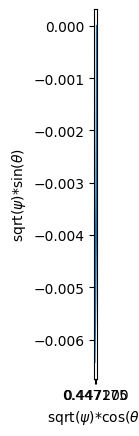

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()

#create simple line plot

ax.plot(np.sqrt(solution[:, 0]) * np.cos(solution[:, 1]), np.sqrt(solution[:, 0]) * np.sin(solution[:, 1]))

#set aspect ratio to 1
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect("equal", adjustable='box')

plt.xlabel(r'sqrt($\psi$)*cos($\theta$)')
plt.ylabel(r'sqrt($\psi$)*sin($\theta$)')
plt.show()

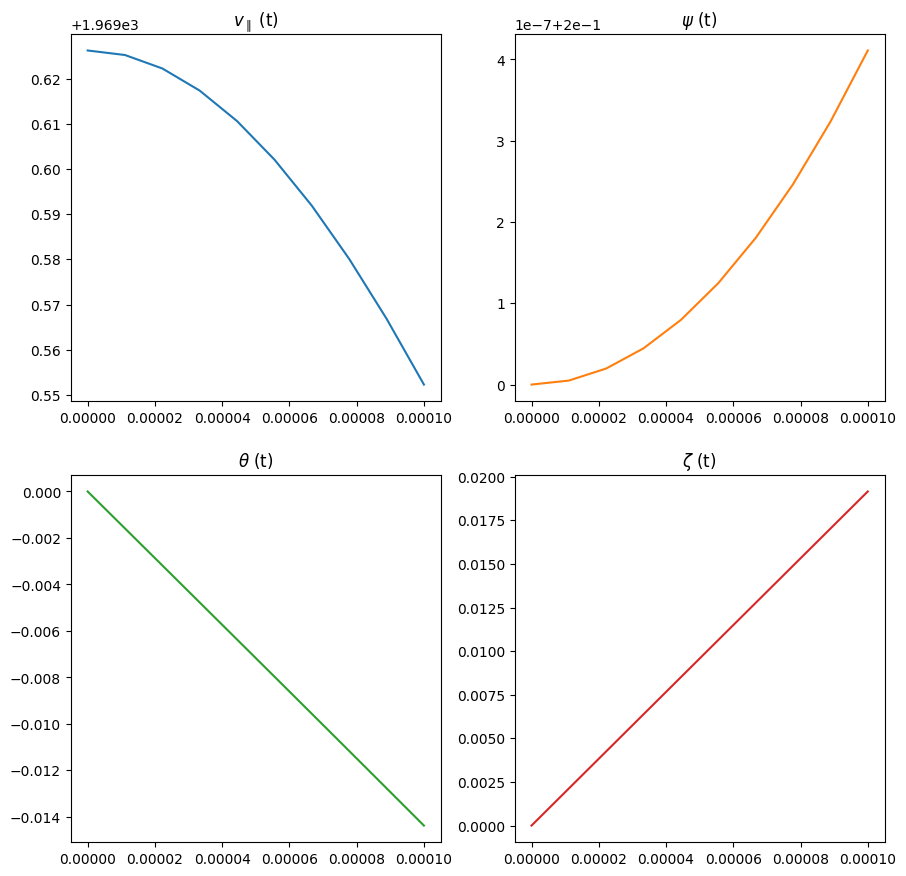

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 1].plot(time, solution[:, 0], 'tab:orange')
axs[0, 1].set_title(r'$\psi$ (t)')
axs[1, 0].plot(time, solution[:, 1], 'tab:green')
axs[1, 0].set_title(r'$\theta$ (t)')
axs[1, 1].plot(time, solution[:, 2], 'tab:red')
axs[1, 1].set_title(r'$\zeta$ (t)')
axs[0, 0].plot(time, solution[:, 3], 'tab:blue')
axs[0, 0].set_title(r"$v_{\parallel}$ (t)")

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)

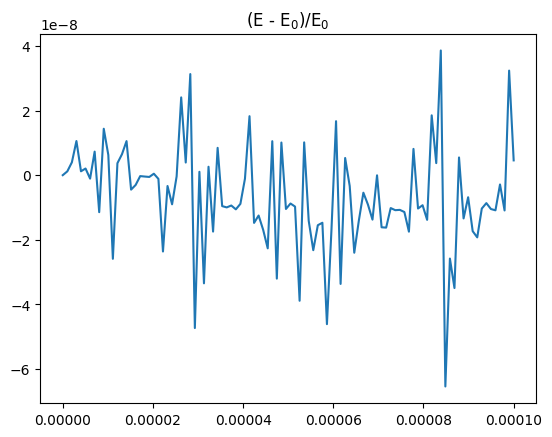

In [ ]:
grid = Grid(np.vstack((np.sqrt(solution[:, 0]), solution[:, 1], solution[:, 2])).T,sort=False)
B_field = eq.compute("|B|", grid=grid)
Energy = 0.5*(solution[:, 3]**2 + 2*B_field["|B|"]*mu)*Mass

plt.plot(time, (Energy-Energy_SI)/Energy_SI)
plt.title(r"(E - E$_0$)/E$_0$")
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))